# Linear Regression and Neural Network models
## Step by step plan:

Data ingestion<br>

Data wrangling and feature engineering
- Outlier removal<br>
- Tokenization and cleanup of job titles<br>
- Creation of dummies for all categorical variables<br>

*Train test split*<br>

Post split wrangling<br>
- Feature selection and database cleanup<br>
- Independent variable normalization<br>

### Model creation and evaluation
- Parameter evaluation<br>
- Actual vs predicted target variable analysis<br>
- Residuals analysis<br>

### Created models:
- One linear model<br>
- One linear model using exclusively significant independent variables<br>
- One neural network model<br>
- One linear model using PCA (some exploratory analysis is done for PCA results)<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import ceil, floor
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, kstest, pearsonr
from scipy.special import inv_boxcox

In [2]:
sns.set() # makes all charts look better by default

## Data Ingestion

In [3]:
#aijobs = pd.read_csv(r'https://ai-jobs.net/salaries/download/salaries.csv')
aijobs = pd.read_csv(r'C:\Users\Captain\Documents\CURSOS\MBA ESALQ\salaries.csv')
# Last accessed at 2024-03-23

In [4]:
aijobs # first look at the data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Data Engineer,120000,CHF,136363,CH,50,CH,L
1,2024,SE,PT,Data Architect,212000,USD,212000,US,0,US,M
2,2024,SE,PT,Data Architect,93300,USD,93300,US,0,US,M
3,2024,MI,FT,Data Product Owner,321830,USD,321830,US,0,US,M
4,2024,MI,FT,Data Product Owner,124690,USD,124690,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
14796,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
14797,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
14798,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
14799,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [5]:
aijobs.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,14801.000000,14801,14801,14801,1.480100e+04,14801,14801.000000,14801,14801.000000,14801,14801
unique,NaN,4,4,152,NaN,23,NaN,88,NaN,77,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,9673,14735,3158,NaN,13648,NaN,12896,NaN,12945,13638
mean,2023.136748,NaN,NaN,NaN,1.650843e+05,NaN,149895.249307,NaN,32.801838,NaN,NaN
std,0.700349,NaN,NaN,NaN,3.566669e+05,NaN,69037.515089,NaN,46.502476,NaN,NaN
min,2020.000000,NaN,NaN,NaN,1.400000e+04,NaN,15000.000000,NaN,0.000000,NaN,NaN
25%,2023.000000,NaN,NaN,NaN,1.021000e+05,NaN,102000.000000,NaN,0.000000,NaN,NaN
50%,2023.000000,NaN,NaN,NaN,1.422000e+05,NaN,141525.000000,NaN,0.000000,NaN,NaN
75%,2024.000000,NaN,NaN,NaN,1.875000e+05,NaN,185900.000000,NaN,100.000000,NaN,NaN


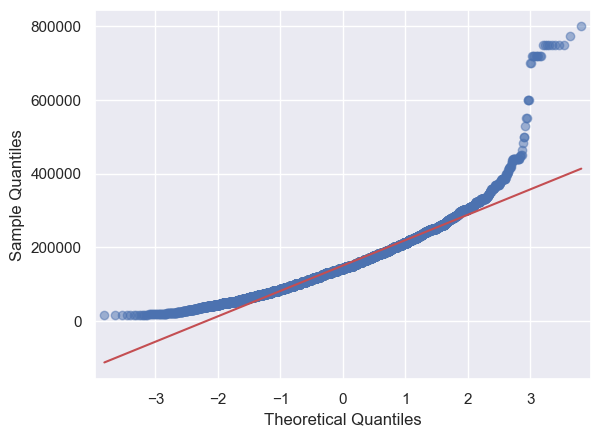

In [6]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

# Common data wrangling
These steps would be equally done for train and test bases with no population or sampled information, only individual ones, so no data leakage will occur if done now.

### Outlier removal

In [7]:
# The first outliers are extremely out of touch with the remainder of the database.
# They will skew the results too much and must be removed.
# According to Hair, from 2.5 to 4 standards deviations might be used to remove outliers.
# Visually, 4 deviations cover the worst cases.

mean = aijobs['salary_in_usd'].mean()
std = aijobs['salary_in_usd'].std()
outmax = mean + 2.5 * std
print(outmax)
outliers = aijobs[aijobs['salary_in_usd'] > outmax].index
print(outliers)
print(len(outliers))

aijobs.drop(outliers, inplace=True)
aijobs.reset_index(drop=True, inplace=True)
aijobs.sort_values('salary_in_usd', ascending=False).head()

322489.0370309836
Index([  153,   157,   213,   230,   237,   320,   370,   410,   428,   455,
       ...
       13453, 13632, 14474, 14526, 14531, 14583, 14728, 14747, 14793, 14796],
      dtype='int64', length=241)
241


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3475,2024,SE,FT,Machine Learning Engineer,322000,USD,322000,US,100,US,M
3682,2024,SE,FT,Machine Learning Engineer,322000,USD,322000,US,100,US,M
513,2024,SE,FT,Data Scientist,322000,USD,322000,US,0,US,M
3,2024,MI,FT,Data Product Owner,321830,USD,321830,US,0,US,M
1879,2024,SE,FT,Research Scientist,321000,USD,321000,US,100,US,M


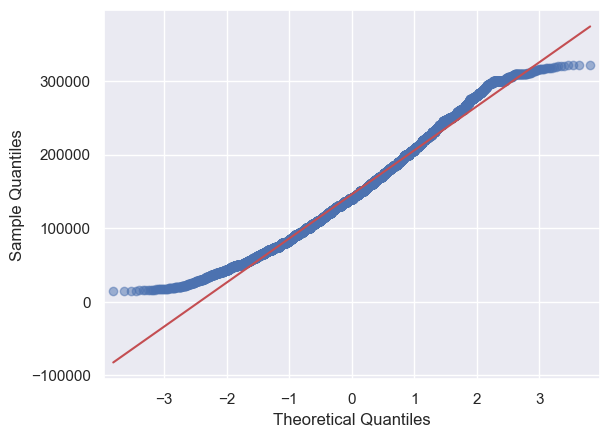

In [8]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

In [9]:
aijobs.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,14560.000000,14560,14560,14560,1.456000e+04,14560,14560.000000,14560,14560.000000,14560,14560
unique,NaN,4,4,150,NaN,22,NaN,87,NaN,77,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,9497,14496,3143,NaN,13416,NaN,12668,NaN,12716,13411
mean,2023.133036,NaN,NaN,NaN,1.611725e+05,NaN,145771.642239,NaN,33.063187,NaN,NaN
std,0.699676,NaN,NaN,NaN,3.578791e+05,NaN,59893.563509,NaN,46.598261,NaN,NaN
min,2020.000000,NaN,NaN,NaN,1.400000e+04,NaN,15000.000000,NaN,0.000000,NaN,NaN
25%,2023.000000,NaN,NaN,NaN,1.000000e+05,NaN,100000.000000,NaN,0.000000,NaN,NaN
50%,2023.000000,NaN,NaN,NaN,1.402500e+05,NaN,140000.000000,NaN,0.000000,NaN,NaN
75%,2024.000000,NaN,NaN,NaN,1.850000e+05,NaN,185000.000000,NaN,100.000000,NaN,NaN


## Feature Engineering

In [10]:
# There is no value in local currency salaries as they're not scaled.
# Salary in USD conveys the same useful information in a scaled manner.
aijobs.drop('salary', axis=1, inplace=True)

In [11]:
# An interesting variable to research
aijobs['work_abroad'] = aijobs['employee_residence'] != aijobs['company_location']
aijobs['work_abroad'] = aijobs['work_abroad'].astype(int)
aijobs.tail(10)

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,work_abroad
14550,2020,MI,FT,Data Engineer,USD,130800,ES,100,US,M,1
14551,2020,SE,FT,Machine Learning Engineer,EUR,45618,HR,100,HR,S,0
14552,2021,SE,FT,Director of Data Science,USD,168000,JP,0,JP,S,0
14553,2021,MI,FT,Data Scientist,SGD,119059,SG,100,IL,M,1
14554,2021,MI,FT,Data Engineer,EUR,28369,MT,50,MT,L,0
14555,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,0
14556,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,0
14557,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,0
14558,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,0
14559,2021,SE,FT,Data Science Manager,INR,94665,IN,50,IN,L,0


In [12]:
# remote_ratio is categorical; the correct way to interpret those numbers is:
#   0 == On Site (less than 20% remote)
#  50 == Partially remote/hybird
# 100 == Fully remote (more than 80% remote)
# therefore using it as numerical would be creating a spurious relationship.
# It has to be dummified and will be switched for easier interpretation.

aijobs.loc[aijobs['remote_ratio'] == 0, 'remote_ratio'] = 'On_Site'
aijobs.loc[aijobs['remote_ratio'] == 50, 'remote_ratio'] = 'Hybrid'
aijobs.loc[aijobs['remote_ratio'] == 100, 'remote_ratio'] = 'Remote'

aijobs['remote_ratio']

0         Hybrid
1        On_Site
2        On_Site
3        On_Site
4        On_Site
          ...   
14555     Remote
14556     Remote
14557     Remote
14558     Remote
14559     Hybrid
Name: remote_ratio, Length: 14560, dtype: object

In [13]:
# Categorical columns will receive appropriate treatment
categorical_columns = ['employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 
                       'company_location', 'company_size']

In [14]:
# Quick look at job titles. This will receive a quick NLP method for processing.
print(len(aijobs['job_title'].unique()), "different job titles \n")
print(aijobs['job_title'].unique())

150 different job titles 

['Data Engineer' 'Data Architect' 'Data Product Owner' 'MLOps Engineer'
 'Data Specialist' 'Data Manager' 'Analytics Engineer' 'Data Analyst'
 'Machine Learning Scientist' 'Business Intelligence Engineer'
 'Data Scientist' 'Business Intelligence Analyst' 'Data Science'
 'Data Analytics Manager' 'Encounter Data Management Professional'
 'Machine Learning Engineer' 'Research Scientist' 'Research Engineer'
 'AI Engineer' 'Data Modeler' 'Research Analyst' 'ML Engineer'
 'Data Science Consultant' 'Applied Scientist' 'BI Analyst'
 'Data Integration Engineer' 'Data Integration Specialist'
 'Machine Learning Operations Engineer'
 'Machine Learning Infrastructure Engineer' 'Data Developer'
 'Business Intelligence' 'CRM Data Analyst' 'ETL Developer'
 'Business Intelligence Manager' 'Data Science Engineer' 'AI Architect'
 'Robotics Engineer' 'BI Developer' 'Head of Data' 'Data Science Manager'
 'Cloud Database Engineer' 'Data Operations Analyst'
 'Data Science Analyst' 

In [15]:
# Work on the terms contained in job titles.
terms = []
for title in aijobs['job_title'].unique():
    for word in title.split():
        terms.append(word)
terms = sorted(set(terms))
print(len(terms), "different terms in these titles \n")
print(terms)

80 different terms in these titles 

['&', 'AI', 'AWS', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous', 'Azure', 'BI', 'Big', 'Biologist', 'Business', 'CRM', 'Cloud', 'Compliance', 'Computational', 'Computer', 'Consultant', 'Data', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Encounter', 'Engineer', 'Finance', 'Financial', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Intelligence', 'Lead', 'Learning', 'ML', 'MLOps', 'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Modeler', 'Modeller', 'NLP', 'Operations', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Professional', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Research', 'Researcher', 'Robotics', 'Sales', 'Science', 'Scientist', 'Software', 'Specialist', 'Staff', 'Strategist', 'Strategy', 'Technician', 'Vehicle', 'Vision', 'Visualization', 'of']


In [16]:
stop_words = ['&', 'of', 'Data', 'Learning', 'Computational', 'Computer', 'Autonomous', 'Technician', 'Professional']
# Justification: '&', 'of' and 'Data' are too generic for this project.
# 'Learning' has two contexts: Machine Learning and Deep Learning, yet both "Machine" and "Deep" are unique to them,
# so there's nothing to be gained from adding it.
# "Autonomous Vehicle Technician" is a job title whose words are all unique, so a single one is enough.
# "Computational Biologist" shares the same issue.
# "Encounter Data Management Professional" is the only to use "Encounter" and "Professional".
# "Computer Vision" is present in more than one job, but all of them use this same sequence, so it's the same situation.

In [17]:
synonym_terms = ['ML','Machine','MLOps', 'Operations','Business','BI','Intelligence','AWS','Cloud','Azure','Modeller',
                 'Modeler','Engineering','Engineer','Financial','Finance','Researcher','Research','Science','Scientist',
                 'Strategy','Strategist','Management','Manager', 'Managing']

In [18]:
# this uses the same pressupositions as above, but some words will mean the same thing.
synonyms = {'Machine': 'Machine|ML|MLOps',      # ML is short for Machine Learning
            'Operations':'MLOps|Operations',    # Ops is short for Operations
            'Intelligence':'Intelligence|BI',   # BI is short for Business Intelligence (Intelligence is exclusive to BI)
            'Business':'Business|BI',           # For consistency (Business is not exclusive to BI)
            'Cloud':'Cloud|AWS|Azure',          # There is a single instance for AWS and for Azure; both specific cloud tools
            'Modeler':'Modeler|Modeller',
            'Engineer':'Engineer|Engineering',
            'Finance':'Finance|Financial',
            'Research':'Research|Researcher',
            'Scientist':'Scientist|Science',
            'Strategist':'Strategist|Strategy',
            'Manager':'Management|Manager|Managing'}
# Note: Analyst and Analytics in this context will mean different things.

In [19]:
clean_terms = terms.copy()                                                   # copy method to keep the original list
[clean_terms.remove(term) for term in stop_words if term in clean_terms]     # remove stop words
[clean_terms.remove(term) for term in synonym_terms if term in clean_terms]  # synonyms will be processed differently
print(len(clean_terms), "terms after cleaning\n", len(synonyms), "synonyms\n ", len(clean_terms)+len(synonyms), "total terms\n")
print(clean_terms)

47 terms after cleaning
 12 synonyms
  59 total terms

['AI', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Big', 'Biologist', 'CRM', 'Compliance', 'Consultant', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Encounter', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Lead', 'Marketing', 'NLP', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Robotics', 'Sales', 'Software', 'Specialist', 'Staff', 'Vehicle', 'Vision', 'Visualization']


In [20]:
# dummization for all chosen job keywords
for job_string in clean_terms:
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(job_string, case=False).astype(int)
for job_string in synonyms.keys():
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(f'{synonyms[job_string]}', case=False).astype(int)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,job_name_Intelligence,job_name_Business,job_name_Cloud,job_name_Modeler,job_name_Engineer,job_name_Finance,job_name_Research,job_name_Scientist,job_name_Strategist,job_name_Manager
0,2024,MI,FT,Data Engineer,CHF,136363,CH,Hybrid,CH,L,...,0,0,0,0,1,0,0,0,0,0
1,2024,SE,PT,Data Architect,USD,212000,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
2,2024,SE,PT,Data Architect,USD,93300,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
3,2024,MI,FT,Data Product Owner,USD,321830,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
4,2024,MI,FT,Data Product Owner,USD,124690,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# dummization for all other categorical columns
df_dummies = pd.get_dummies(aijobs[categorical_columns], dtype=int)
aijobs = pd.concat([aijobs, df_dummies], axis=1)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_location_ZA,company_size_L,company_size_M,company_size_S
0,2024,MI,FT,Data Engineer,CHF,136363,CH,Hybrid,CH,L,...,0,0,0,0,0,0,0,1,0,0
1,2024,SE,PT,Data Architect,USD,212000,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
2,2024,SE,PT,Data Architect,USD,93300,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
3,2024,MI,FT,Data Product Owner,USD,321830,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
4,2024,MI,FT,Data Product Owner,USD,124690,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0


In [22]:
aijobs[categorical_columns].describe().loc['unique']

employment_type        4
salary_currency       22
employee_residence    87
remote_ratio           3
company_location      77
company_size           3
Name: unique, dtype: object

In [23]:
# To establish the features, categorical columns that are not dummies will need to be removed. Target variable too.

X_vars = aijobs.columns.tolist()
[X_vars.remove(col) for col in categorical_columns if col in X_vars]
X_vars.remove('job_title')
X_vars.remove('salary_in_usd')
X_vars.remove('experience_level')

In [24]:
# Comprehensive dummies will need one instance removed.
# They could be picked by hand, but the algorithm below selects the most popular for deletion.

c_dummies = aijobs[['employment_type_FL', 'employment_type_PT', 'employment_type_CT', 'employment_type_FT']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['remote_ratio_Remote', 'remote_ratio_Hybrid', 'remote_ratio_On_Site']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['company_size_S', 'company_size_M', 'company_size_L']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

# These larger dummies will be implied in the intercept.
X_vars.remove('salary_currency_USD')
X_vars.remove('employee_residence_US')
X_vars.remove('company_location_US')

print(X_vars)

['work_year', 'work_abroad', 'job_name_AI', 'job_name_Admin', 'job_name_Analyst', 'job_name_Analytics', 'job_name_Applied', 'job_name_Architect', 'job_name_Associate', 'job_name_Big', 'job_name_Biologist', 'job_name_CRM', 'job_name_Compliance', 'job_name_Consultant', 'job_name_Database', 'job_name_Decision', 'job_name_Deep', 'job_name_DevOps', 'job_name_Developer', 'job_name_Director', 'job_name_ETL', 'job_name_Encounter', 'job_name_Head', 'job_name_Infrastructure', 'job_name_Insight', 'job_name_Integration', 'job_name_Lead', 'job_name_Marketing', 'job_name_NLP', 'job_name_Ops', 'job_name_Owner', 'job_name_Pipeline', 'job_name_Power', 'job_name_Practitioner', 'job_name_Principal', 'job_name_Product', 'job_name_Programmer', 'job_name_Prompt', 'job_name_Quality', 'job_name_Quantitative', 'job_name_Reporting', 'job_name_Robotics', 'job_name_Sales', 'job_name_Software', 'job_name_Specialist', 'job_name_Staff', 'job_name_Vehicle', 'job_name_Vision', 'job_name_Visualization', 'job_name_Machi

# Splitting and working the data before model fit

In [25]:
aijobs['experience_level'].unique()

array(['MI', 'SE', 'EN', 'EX'], dtype=object)

In [93]:
X_train = {}
X_test = {}
y_train = {}
y_test = {}
lmbda = 0.4725 #selected from the best performing model previously

for exp in aijobs['experience_level'].unique():
    X_train[exp], X_test[exp], y_train[exp], y_test[exp] = train_test_split(aijobs[aijobs['experience_level'] == exp][X_vars], 
                                                                            aijobs[aijobs['experience_level'] == exp]['salary_in_usd'], 
                                                                            test_size=0.25, random_state=42)
    y_vals = boxcox(y_train[exp], lmbda)
    y_train[exp] = pd.Series(y_vals, index=y_train[exp].index, name='transformed_salary')
    y_vals = boxcox(y_test[exp], lmbda)
    y_test[exp] = pd.Series(y_vals, index=y_test[exp].index, name='transformed_salary')

In [27]:
X_train['MI']

,work_year,work_abroad,job_name_AI,job_name_Admin,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Associate,job_name_Big,...,company_location_SE,company_location_SG,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_VN,company_location_ZA,company_size_L,company_size_S
5274,2023,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1283,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
403,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14257,2022,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9868,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,2024,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3647,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4132,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2849,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
# To delete columns with too few instances in order to avoid overfitting
# Hair says 5 entries is a minimum threshold; any dummy with less than 5 examples is too prone to overfitting.

def del_vars(X_train, X_test, y_train, y_test, printing=False):
    """
    This function deletes all columns in training base that have too few instances and will result in overfitting
    It also deletes every row that had an instance in such columns in order to prevent assumptions implied in the intecept
    As these variables are rendered unworkable, they are also deleted from test base (no information leak happens)
    Every row removed from independent variables bases (X) is also removed from the dependent variable array (y).
    """
    
    if printing == True:
        print("Before:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    deletions = 1 #just to enter the loop
    train_dropped = []
    while deletions > 0:
        deletions = X_train.shape[0] # store the dataframe size for later comparison
        X_sum = X_train.sum()
        exclusion_list = X_sum[X_sum < 5].index # create the exclusion column list

        # deleting all rows with any positive value in those variables
        X_delete = X_train[exclusion_list].sum(axis=1)
        rows_to_delete = X_delete[X_delete != 0]
        X_train.drop(rows_to_delete.index, inplace=True)
        
        [train_dropped.append(item) for item in rows_to_delete.index] # list all deleted rows for later consistency wity y array
        deletions = deletions - X_train.shape[0] # difference from previous dataframe size
        if printing == True:
            print('Rows deleted:', deletions) # deleted rows in this loop
            print('Columns dropped:', len(exclusion_list)) # cumulative columns to be deleted
        # loop until there are no more deleted rows
        
    X_train.drop(exclusion_list, axis=1, inplace=True) # dropping columns from train base now
    
    test_deletion = X_test[exclusion_list].sum(axis=1) # filter a dataframe by select all exclusion rows and their sum
    test_dropped = test_deletion[test_deletion > 0].index # finding all rows with a positive value on any of those dummies
    X_test.drop(test_dropped, inplace=True) # dropping unworkable test rows
    X_test.drop(exclusion_list, axis=1, inplace=True) # dropping columns from test base
    
    # shaping dependent variable arrays to match independent variables dataframes
    y_train.drop(train_dropped, inplace=True)
    y_test.drop(test_dropped, inplace=True)
    if printing == True:
        print("After:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [95]:
for exp in aijobs['experience_level'].unique():
    print(exp)
    del_vars(X_train[exp], X_test[exp], y_train[exp], y_test[exp], printing=True)
    print('\n')

MI
Before: (2627, 251) (2627,) (876, 251) (876,)
Rows deleted: 130
Columns dropped: 176
Rows deleted: 13
Columns dropped: 185
Rows deleted: 0
Columns dropped: 185
After: (2484, 66) (2484,) (825, 66) (825,)


SE
Before: (7122, 251) (7122,) (2375, 251) (2375,)
Rows deleted: 81
Columns dropped: 166
Rows deleted: 3
Columns dropped: 168
Rows deleted: 0
Columns dropped: 168
After: (7038, 83) (7038,) (2333, 83) (2333,)


EN
Before: (858, 251) (858,) (286, 251) (286,)
Rows deleted: 99
Columns dropped: 204
Rows deleted: 17
Columns dropped: 211
Rows deleted: 0
Columns dropped: 211
After: (742, 40) (742,) (243, 40) (243,)


EX
Before: (312, 251) (312,) (104, 251) (104,)
Rows deleted: 23
Columns dropped: 228
Rows deleted: 3
Columns dropped: 231
Rows deleted: 0
Columns dropped: 231
After: (286, 20) (286,) (87, 20) (87,)




In [96]:
for exp in aijobs['experience_level'].unique():
    X_train[exp] = sm.add_constant(X_train[exp])
    X_test[exp] = sm.add_constant(X_test[exp])

# Starting the Model

In [97]:
# Create a model

def model_creation(X_train, X_test, y_train, y_test):
    # A few variables look like they still have high p-values even in an isolated model.
    # Loop until only significant variables are present
    NOT_significant_vars = [1] # creation of a non empty list to enter the loop
    while NOT_significant_vars != []:
        # The model is created, but a new one using only the previously resulting significant variables 
        # did not render a new model that had all variables resulting significant.
        # A stepwise deletion for these variables will be done here until that happens.
        OLS_model = sm.OLS(y_train, X_train).fit()
        y_pred = OLS_model.predict(X_test)

        # Bring all not significant variables into a single list
        NOT_significant_vars = OLS_model.pvalues[OLS_model.pvalues > 0.05]
        NOT_significant_vars = list(NOT_significant_vars.index)

        # remove the intercept from this list so it isn't removed from the model
        if 'const' in NOT_significant_vars:
            NOT_significant_vars.remove('const')

        X_train.drop(NOT_significant_vars, axis=1, inplace=True)
        X_test.drop(NOT_significant_vars, axis=1, inplace=True)
        del_vars(X_train, X_test, y_train, y_test, printing=True)
    
    return OLS_model

In [98]:
# Predictions and summary
y_pred = {}
OLS_model = {}
      
for exp in aijobs['experience_level'].unique():
    OLS_model[exp] = model_creation(X_train[exp], X_test[exp], y_train[exp], y_test[exp])
    y_pred[exp] = OLS_model[exp].predict(X_test[exp])
    display(OLS_model[exp].summary())

Before: (2484, 23) (2484,) (825, 23) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 23) (2484,) (825, 23) (825,)
Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)
Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     53.12
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          1.80e-160
Time:                        22:25:34   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3096      3.805    128.584      0.000     481.848     496.772
job_name_Applied         75.1104     11.854      6.336      0.000      51.866      98.355
job_name_Architect       81.9731     22.852      3.587      0.000      37.161     126.785
job_name_Consultant     -53.9694     25.231     -2.139      0.033    -103.445      -4.493
job_name_Product         87.0325     24.724      3.520      0.000      38.551     135.514
job_name_Machine         56.6344      6.761      8.376      0.000      43.376      69.893
job_name_Operations     -44.7755     20.459     -2.189      0.029     -84.895      -4.656
job_name_Modeler         66.3104     28.810      2.302      0.021       9.815     122.806
job_name_Engineer        54.3332      4.745     11.451      0.000      45.029      63.638
job_name_Research        37.7964      7.836      4.823      0.000      22.430      53.163
job_name_Scientist       63.0943      4.922     12.819      0.000      53.443      72.746
job_name_Manager         31.9511      8.428      3.791      0.000      15.423      48.479
salary_currency_CAD    -103.5960     32.154     -3.222      0.001    -166.648     -40.544
salary_currency_GBP    -117.6811      6.491    -18.130      0.000    -130.409    -104.953
employee_residence_BR   -59.4242     17.155     -3.464      0.001     -93.064     -25.785
employee_residence_GR   -84.0428     17.131     -4.906      0.000    -117.635     -50.450
employee_residence_LV   -85.0410     20.240     -4.202      0.000    -124.730     -45.351
remote_ratio_Remote     -17.9142      4.137     -4.330      0.000     -26.026      -9.802
company_location_BR     -59.4242     17.155     -3.464      0.001     -93.064     -25.785
company_location_GR     -84.0428     17.131     -4.906      0.000    -117.635     -50.450
company_location_IN    -288.0768     28.643    -10.058      0.000    -344.243    -231.911
company_location_LV     -85.0410     20.240     -4.202      0.000    -124.730     -45.351
==============================================================================
Omnibus:                        7.360   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.388
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Before: (7038, 32) (7038,) (2333, 32) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 32) (7038,) (2333, 32) (2333,)
Before: (7038, 30) (7038,) (2333, 30) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 30) (7038,) (2333, 30) (2333,)
Before: (7038, 28) (7038,) (2333, 28) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 28) (7038,) (2333, 28) (2333,)
Before: (7038, 28) (7038,) (2333, 28) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 28) (7038,) (2333, 28) (2333,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     119.1
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:25:34   Log-Likelihood:                -41320.
No. Observations:                7038   AIC:                         8.269e+04
Df Residuals:                    7013   BIC:                         8.286e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.305e+04   3464.831     -3.765      0.000   -1.98e+04   -6254.074
work_year                 6.7110      1.713      3.919      0.000       3.354      10.068
work_abroad             -62.1284     26.779     -2.320      0.020    -114.624      -9.632
job_name_AI              31.6642     10.361      3.056      0.002      11.353      51.975
job_name_Applied         37.6670      6.106      6.169      0.000      25.697      49.637
job_name_Architect       80.6647      5.878     13.722      0.000      69.141      92.188
job_name_Consultant     -93.1629     13.108     -7.107      0.000    -118.859     -67.467
job_name_Lead            27.6830     13.647      2.029      0.043       0.931      54.435
job_name_Principal      107.2238     30.983      3.461      0.001      46.488     167.959
job_name_Quality        -52.7456     21.588     -2.443      0.015     -95.064     -10.427
job_name_Vision          81.3846     19.959      4.078      0.000      42.260     120.510
job_name_Machine         56.4046      3.155     17.879      0.000      50.220      62.589
job_name_Engineer        65.1860      3.029     21.520      0.000      59.248      71.124
job_name_Research        36.4856      4.687      7.784      0.000      27.298      45.674
job_name_Scientist       84.4296      3.074     27.469      0.000      78.404      90.455
job_name_Manager         44.5654      6.899      6.460      0.000      31.042      58.089
salary_currency_CAD     -83.7373     21.551     -3.886      0.000    -125.983     -41.492
salary_currency_EUR    -166.8476     12.016    -13.885      0.000    -190.403    -143.293
salary_currency_GBP    -141.7535      8.042    -17.626      0.000    -157.519    -125.988
salary_currency_INR    -280.1296     27.765    -10.089      0.000    -334.558    -225.701
employee_residence_CO   -91.7612     17.564     -5.224      0.000    -126.193     -57.329
employee_residence_UA   -40.7499     19.338     -2.107      0.035     -78.658      -2.842
employee_residence_ZA   -47.9046     17.898     -2.677      0.007     -82.989     -12.820
company_location_BR    -277.0566     38.667     -7.165      0.000    -352.856    -201.257
company_location_CO     -91.7612     17.564     -5.224      0.000    -126.193     -57.329
company_location_ES     -89.2884     16.033     -5.569      0.000    -120.717     -57.860
company_location_UA     -40.7499     19.338     -2.107      0.035     -78.658      -2.842
company_location_ZA     -47.9046     17.898     -2.677      0.007     -82.989     -12.820
==============================================================================
Omnibus:                       12.944   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.628
Skew:                           0.055   Prob(JB):       

Before: (742, 13) (742,) (243, 13) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 13) (742,) (243, 13) (243,)
Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)
Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     43.11
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           4.74e-51
Time:                        22:25:35   Log-Likelihood:                -4403.0
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5119      4.639    102.925      0.000     468.404     486.620
job_name_Applied      115.0530     28.080      4.097      0.000      59.926     170.180
job_name_Machine       43.0204     14.501      2.967      0.003      14.551      71.489
job_name_Research      71.0071     10.440      6.801      0.000      50.511      91.503
employment_type_PT    -96.1629     29.660     -3.242      0.001    -154.392     -37.933
salary_currency_EUR  -144.6179     15.770     -9.170      0.000    -175.577    -113.658
salary_currency_GBP  -132.1629     12.887    -10.255      0.000    -157.463    -106.863
remote_ratio_Remote   -34.8224      7.583     -4.592      0.000     -49.709     -19.936
==============================================================================
Omnibus:                       14.305   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.034
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Before: (286, 6) (286,) (87, 6) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 6) (286,) (87, 6) (87,)
Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)
Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     7.074
Date:                Tue, 09 Apr 2024   Prob (F-statistic):            0.00100
Time:                        22:25:35   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.8954      7.724     81.288      0.000     612.691     643.100
job_name_Director      52.3093     22.066      2.371      0.018       8.875      95.744
remote_ratio_Remote    35.0994     12.424      2.825      0.005      10.643      59.556
==============================================================================
Omnibus:                        8.953   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.591
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
# Design a function to create a lot of plots
def create_scatter(y_pred, y_test):

    comparison_df = pd.DataFrame((y_test, y_pred, y_test - y_pred)).transpose()
    comparison_df.columns = ["Observed", "Predicted", "Residual"]
    display(comparison_df.describe())

    m, b = np.polyfit(y_test, y_pred, deg=1)
    R_2 = pearsonr(y_test, y_pred)
    
    # Adjusting charts' limits (with a buffer)
    llim = min(y_test.min(), y_pred.min()) - 30
    ulim = max(y_test.max(), y_pred.max()) + 30
    llim = floor(llim/100)*100
    ulim = ceil(ulim/100)*100

    print('Scatter plot of Predicted vs Actual values')

    g = sns.jointplot(x=y_test, y=y_pred, kind="reg", height=6.7, xlim=(llim, ulim), ylim=(llim, ulim), 
                      joint_kws={'scatter_kws':dict(alpha=0.2)}, line_kws=dict(color="r"))

    for i in [400, 700]:
        g.refline(x=i, y=i, linestyle=":", alpha=.5)

    plt.xlabel('Observed y values')
    plt.ylabel('Predicted y values')

    plt.show()

    print(f'Prediction R squared: {R_2[0]**2:.4f} p-value: {R_2[1]:.4f}')
    print(f'y = {m:.4f}x {b:+.1f} \n\n')
    
    
    print('RESIDUALS PLOT - SORTED BY ASCENDING OBSERVED DEPENDENT VARIABLE')

    residuals = comparison_df.sort_values('Observed')['Residual']
    
    fig = plt.figure(figsize=(6.3, 3.5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(residuals.values, linewidth=0.1)
    plt.show()
    
    # tests and histogram to look at residuals' normality
    print('RESIDUALS NORMALITY')
    print(kstest(residuals, "norm"))
    print('Residuals Histogram')
    plt.hist(residuals, bins=20)
    plt.show()

,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.100189,572.108627,3.991562
std,113.938141,71.282944,88.784594
min,205.530046,183.318617,-301.360326
25%,497.601961,530.231944,-57.071468
50%,579.108975,595.417957,2.791078
75%,653.339300,614.661574,63.786775
max,841.488869,759.046340,278.214646


Scatter plot of Predicted vs Actual values


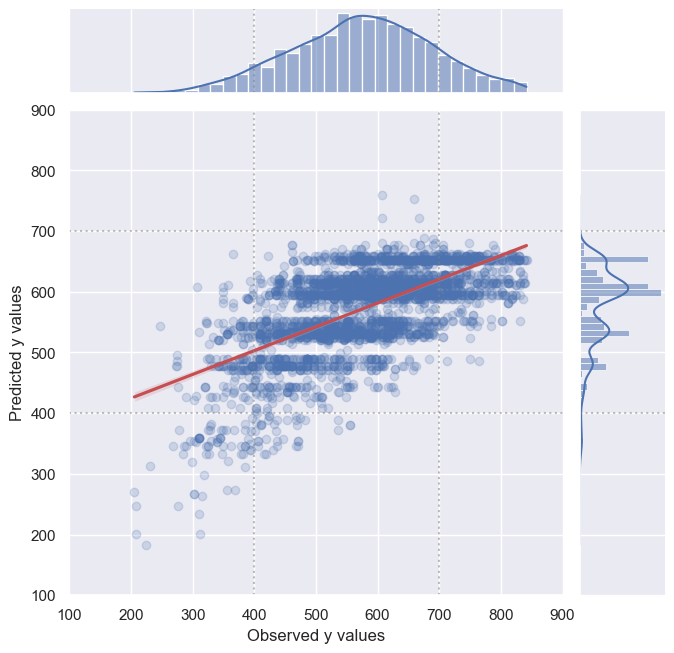

Prediction R squared: 0.3928 p-value: 0.0000
y = 0.3921x +346.2 


RESIDUALS PLOT - SORTED BY ASCENDING OBSERVED DEPENDENT VARIABLE


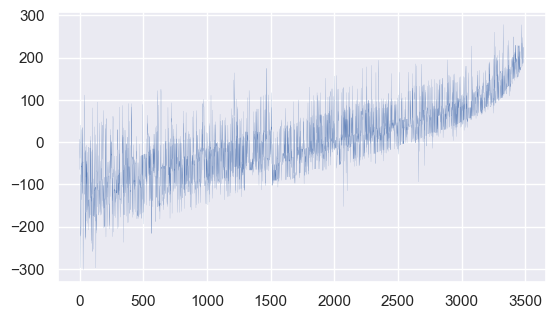

RESIDUALS NORMALITY
KstestResult(statistic=0.49774295961832143, pvalue=0.0, statistic_location=2.706109534810139, statistic_sign=-1)
Residuals Histogram


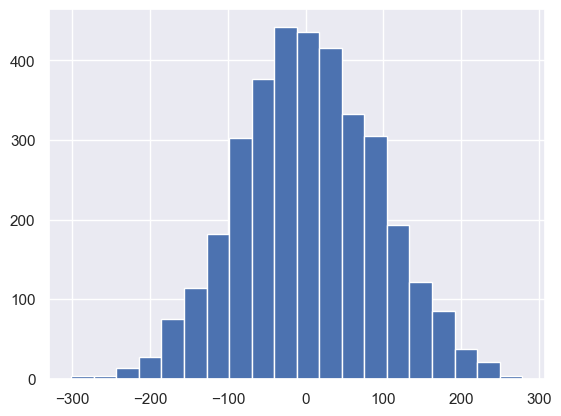

In [100]:
pred = pd.concat([y_pred['MI'], y_pred['SE'], y_pred['EN'], y_pred['EX']])
test = pd.concat([y_test['MI'], y_test['SE'], y_test['EN'], y_test['EX']])
create_scatter(pred, test)